# Transducer Reducer: Resample time-series transducer data, filter outliers
## by Michael J. Murphy, May 2019

Load the transducer data from Excel file; instantiate the DataFrame:

In [1]:
import pandas as pd
from datetime import date
import numpy as np

f = 'transducer_data.xlsx'
df = pd.read_excel(f, infer_datetime_format =True, encoding = 'UTF8')
date = df['TimeStamp']
flow_datetimes = pd.to_datetime(date, infer_datetime_format= True)
df['TimeStamp'] = flow_datetimes

df.drop(df.head(60).index, inplace=True)
df.drop(df.tail(60).index, inplace=True)
df.reset_index(inplace=True)

print(df.head())
print(df.shape)


   index MonitoringPoint           TimeStamp  WaterLevel     TOC         GWE
0     60          ri-35i 2018-11-22 01:00:00    5.098033  296.37  291.271967
1     61          ri-35i 2018-11-22 01:01:00    5.111416  296.37  291.258584
2     62          ri-35i 2018-11-22 01:02:00    5.104249  296.37  291.265751
3     63          ri-35i 2018-11-22 01:03:00    5.099487  296.37  291.270513
4     64          ri-35i 2018-11-22 01:04:00    5.103948  296.37  291.266052
(69620, 6)


Import additional packages, some .plt housekeeping to make things look nice (this can take a while!).

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['figure.figsize'] = (12.0, 7.0)
plt.tight_layout()

<Figure size 864x504 with 0 Axes>

Plot GWE vs. time:

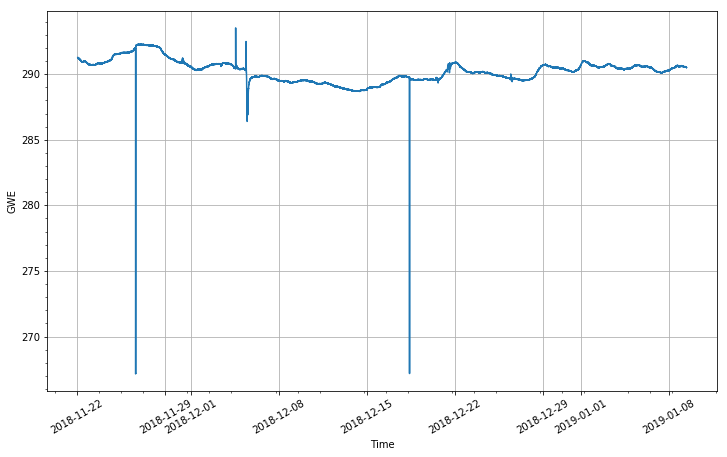

In [4]:
_0 = plt.plot(df['TimeStamp'], df['GWE'])
plt.minorticks_on()
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('GWE')
plt.grid()
plt.show()

Filter outliers by calculating the difference between GWE values, then replacing outliers by linearly interpolating between adjacent values:

In [5]:
for n in np.arange(175):
    df['Diff'] = df['GWE'].diff(periods = n)
    df['GWE'].mask(df.Diff.abs() > 0.5, np.NaN, inplace = True)
    df['GWE'] = df['GWE'].interpolate(method='linear', limit=175)
    
df1 = df

print(df1.head())
print(df1.tail())
print(df1.shape)

   index MonitoringPoint           TimeStamp  WaterLevel     TOC         GWE  \
0     60          ri-35i 2018-11-22 01:00:00    5.098033  296.37  291.271967   
1     61          ri-35i 2018-11-22 01:01:00    5.111416  296.37  291.258584   
2     62          ri-35i 2018-11-22 01:02:00    5.104249  296.37  291.265751   
3     63          ri-35i 2018-11-22 01:03:00    5.099487  296.37  291.270513   
4     64          ri-35i 2018-11-22 01:04:00    5.103948  296.37  291.266052   

   Diff  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  
       index MonitoringPoint           TimeStamp  WaterLevel     TOC  \
69615  69675          ri-35i 2019-01-09 09:15:00    5.860468  296.37   
69616  69676          ri-35i 2019-01-09 09:16:00    5.862022  296.37   
69617  69677          ri-35i 2019-01-09 09:17:00    5.855807  296.37   
69618  69678          ri-35i 2019-01-09 09:18:00    5.860569  296.37   
69619  69679          ri-35i 2019-01-09 09:19:00    5.857361  296.37   

              GWE      Dif

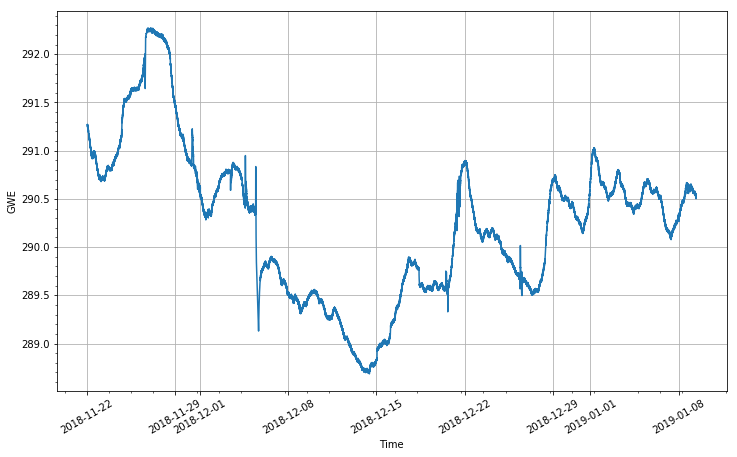

In [6]:
_1 = plt.plot(df1['TimeStamp'], df1['GWE'])
plt.minorticks_on()
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('GWE')
plt.grid()
plt.show()

Resample (in this case, downsample) the transducer data to 1-hour intervals on the mean value of the interval:

In [7]:
interval = '1H'
df_resamp = df1.resample(interval, on='TimeStamp').mean()
df_resamp.reset_index(inplace=True)
df_resamp.dropna(inplace=True)
df_resamp.reset_index(inplace=True)

print(df_resamp.head())
print(df_resamp.shape)

   level_0           TimeStamp  index  WaterLevel     TOC         GWE  \
0        2 2018-11-22 03:00:00  209.5    5.191103  296.37  291.178897   
1        3 2018-11-22 04:00:00  269.5    5.227291  296.37  291.142709   
2        4 2018-11-22 05:00:00  329.5    5.268348  296.37  291.101652   
3        5 2018-11-22 06:00:00  389.5    5.312324  296.37  291.057676   
4        6 2018-11-22 07:00:00  449.5    5.363277  296.37  291.006723   

       Diff  
0 -0.098468  
1 -0.106033  
2 -0.117242  
3 -0.117461  
4 -0.130849  
(1159, 7)


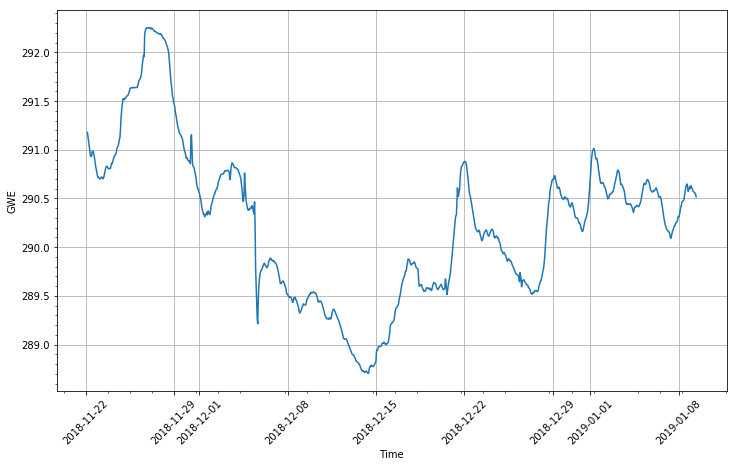

In [8]:
_2 = plt.plot(df_resamp['TimeStamp'], df_resamp['GWE'])
plt.minorticks_on()
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('GWE')
plt.grid()
plt.show()

We have now filtered out most of the outliers, and reduced the size of the transducer data set by  a factor of nearly 70, all while retaining the changes in groundwater elevation! 